In [1]:
pip install mmcv-full

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


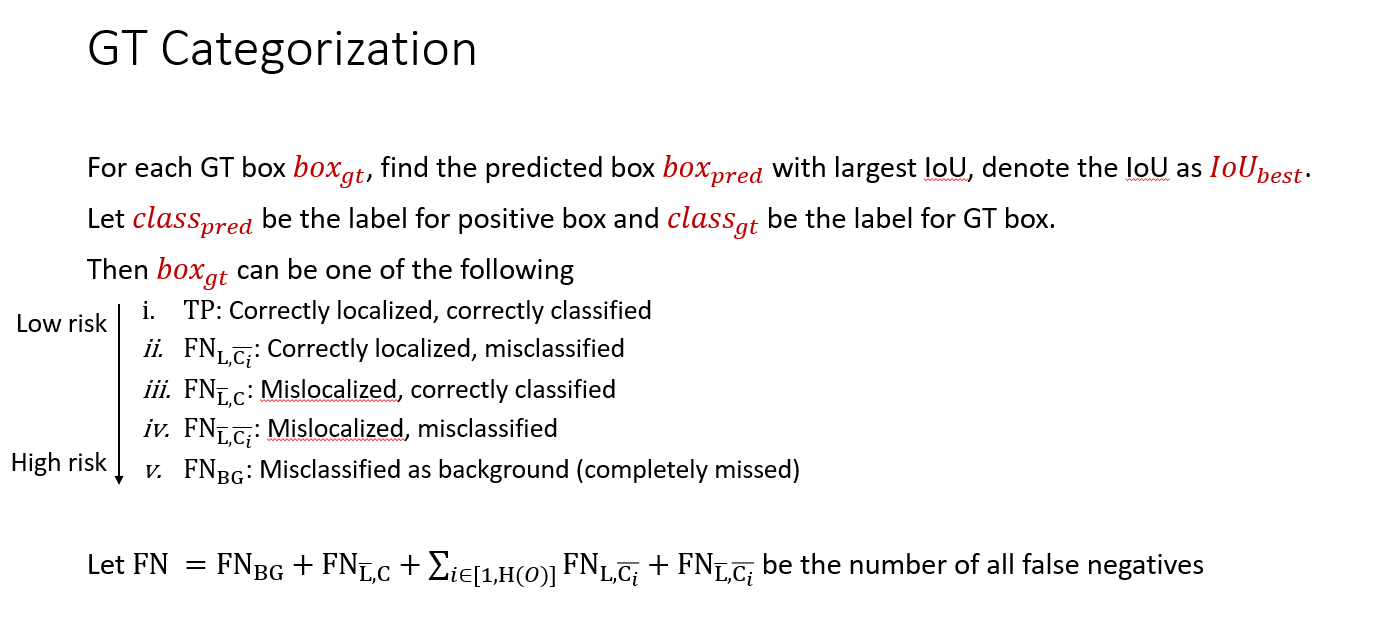

In [2]:
%load_ext autoreload
%autoreload 2

import os
from pprint import pprint

import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D

from detection import Detection
from filter import ClassFilter, RangeFilter, CombinedFilter

print(os.getcwd())

/root/workspace/wise_alf_merge/wise_alf/metrics/detection


In [3]:
dataset_path = '/root/workspace/datasets/kitti'
logdir = '/root/workspace/logdir/al_log/kittidataset/pointpillar/random_init_150/constant_qbs_50/65535/init_model/output/test'
gts_path = os.path.join(logdir, 'gts.pkl')
preds_path = os.path.join(logdir, 'preds.pkl')

In [4]:
def load_dicts():
    # Load gt and prediction data dict
    with open(gts_path, 'rb') as f:
        gt_dicts = pickle.load(f)
    with open(preds_path, 'rb') as f:
        pred_dicts = pickle.load(f)
    return gt_dicts, pred_dicts

def load_image(frame_id):
    img_path = os.path.join(dataset_path, 'training', 'image_2', f'{frame_id}.png')
    return plt.imread(img_path)

def load_lidar(frame_id, xlim, ylim):
    lidar_path = os.path.join(dataset_path, 'training', 'velodyne', f'{frame_id}.bin')
    points = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)
    valid_mask = (points[:,0] > xlim[0]) & \
        (points[:,0] < xlim[1]) & \
        (points[:,1] > ylim[0]) & \
        (points[:,1] < ylim[1]) & \
        (points[:,2] < 4)
    points = points[valid_mask]
    return points

def add_box(ax, box, color=None):
    # box: [x, y, z, w, l, h, theta]
    w = box[3]
    h = box[4]
    xy = (box[0] - w/2, box[1] - h/2)
    angle = box[-1] * 180 / np.pi
    box_rect = Rectangle(
        xy, w, h, facecolor='none', edgecolor=color
    )
    t = Affine2D().rotate_around(box[0], box[1], box[-1]) + ax.transData
    box_rect.set_transform(t)
    ax.add_patch(box_rect)

In [5]:
# Load example GT and prediction
idx = np.random.randint(3700)
# idx = 2322, 291
idx = 2322
print(idx)
gt_dicts, pred_dicts = load_dicts()

print('Example GT dict:')
print(gt_dicts[idx].keys())
print('Example pred dict:')
print(pred_dicts[idx].keys())

2322
Example GT dict:
dict_keys(['gt_boxes', 'gt_labels', 'gt_names', 'frame_id'])
Example pred dict:
dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'boxes_lidar', 'score_all', 'feature', 'frame_id'])


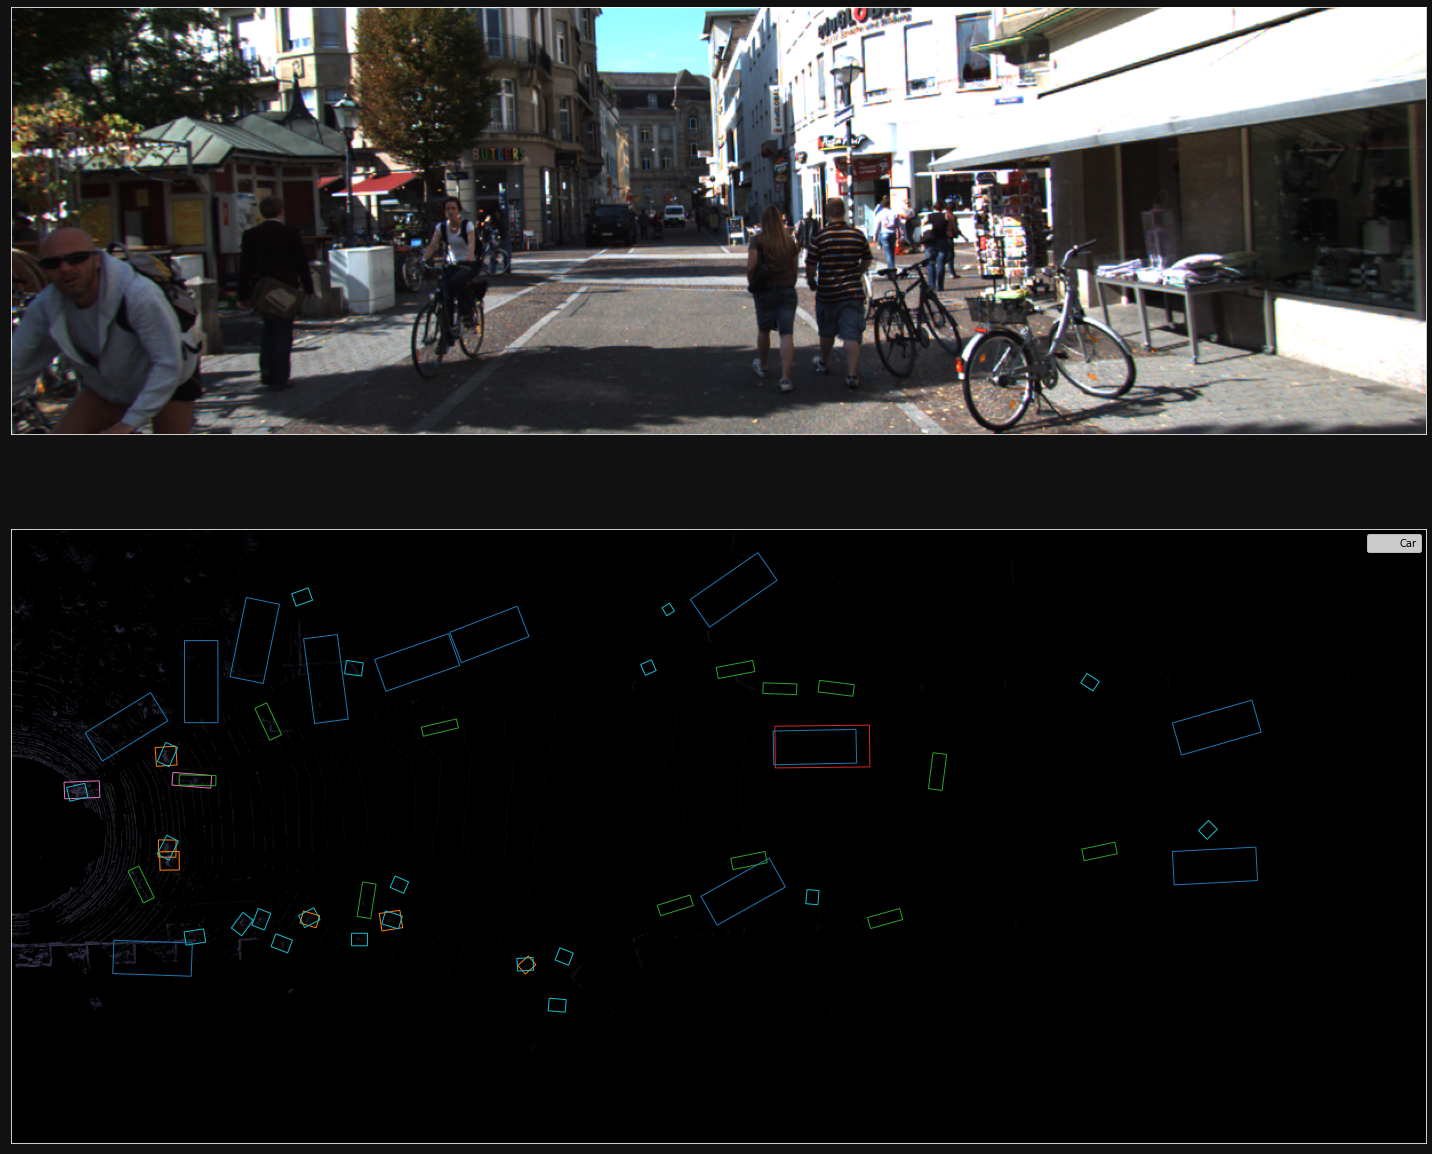

In [6]:
################################################################################
#
# Example: visualization
#
################################################################################

xlim = [0, 69.12]
ylim = [-15, 15]

gt_dict = gt_dicts[idx]
pred_dict = pred_dicts[idx]
points = load_lidar(gt_dict['frame_id'], xlim, ylim)
image = load_image(gt_dict['frame_id'])
scale = 0.32

plt.figure(figsize=(20, 18), facecolor=(0.067, 0.067, 0.067))

ax = plt.subplot(211)
plt.imshow(image)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax = plt.subplot(212)

ax.scatter(points[::-1,0], points[::-1,1], marker='.', s=0.01, c=points[:,3], cmap='bone')

ax.legend(('Car', 'Pedestrian', 'Cyclist'))

class_colors = ['tab:gray', 'tab:red', 'tab:orange', 'tab:pink', 'tab:gray']
for label, box in zip(gt_dict['gt_labels'], gt_dict['gt_boxes']):
    add_box(ax, box, color=class_colors[label])

class_colors = ['tab:gray', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:gray']
for label, box in zip(np.argmax(pred_dict['score_all'][:,:-1], axis=-1)+1, pred_dict['boxes_lidar']):
    add_box(ax, box, color=class_colors[label])
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_facecolor('black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()

In [7]:
def get_labels(data_dict):
    if 'gt_labels' in data_dict:
        return data_dict['gt_labels']
    if 'name' in data_dict:
        classes = ['Car', 'Pedestrian', 'Cyclist']
        return np.array([classes.index(name)+1 for name in data_dict['name']])
    raise ValueError()

def get_boxes(data_dict):
    if 'boxes_lidar' in data_dict:
        return data_dict['boxes_lidar']
    if 'gt_boxes' in data_dict:
        return data_dict['gt_boxes']
    raise ValueError()

def get_scores(data_dict):
    return data_dict['score']
    
def gt_processor(data_dict):
    return ( get_labels(data_dict), get_boxes(data_dict) )

def pred_processor(data_dict):
    return (get_labels(data_dict),
            get_scores(data_dict),
            get_boxes(data_dict))

def get_dist(data_dict):
    boxes = get_boxes(data_dict)
    coords = boxes[:,:2]
    dist = np.linalg.norm(coords, axis=1)
    return dist

In [8]:
################################################################################
# 
# Example: evaluating one sample
#
################################################################################

# Threshold (list or dict) maps a label to a matching threshold
# thresholds[label] = threshold
thresholds = {
    1: 0.7,    # Car
    2: 0.5,    # Pedestrian
    3: 0.5     # Cyclist
}

# Examples for some common filters
# ClassFilter: filter by class, needs to specify class label
# RangeFilter: filter numerical value by a range
# CombinedFilter: combine multiple filters together with an `AND` clause

car_filter = ClassFilter(name='Car', label=1,
                         gt_processor=gt_processor, pred_processor=pred_processor)
ped_filter = ClassFilter(name='Pedestrian', label=2,
                         gt_processor=gt_processor, pred_processor=pred_processor)
cyc_filter = ClassFilter(name='Cyclist', label=3,
                         gt_processor=gt_processor, pred_processor=pred_processor)

dist_filter = RangeFilter(name='0-30m', value_range=(0, 30),
                          gt_processor=get_dist, pred_processor=get_dist)

ped_dist_filter = CombinedFilter([
    ped_filter, dist_filter
])

# Call `evaluate_one_sample` to get the results
gt_list, pred_list = Detection.evaluate_one_sample(
    gt_dicts[idx],
    pred_dicts[idx],
    thresholds,
    criterion='iou',
    epsilon=0.1,
    filta=ped_filter,
    gt_processor=gt_processor,
    pred_processor=pred_processor
)

# The return values are two `BoxList` type object
# Each object contains the following fields
gt_list.keys()

['ignored',
 'bg',
 'localized',
 'loc_scores',
 'classified',
 'gt_labels',
 'pred_labels',
 'pred_scores',
 'data']

In [9]:
# BoxList can be indexed in may ways
gt_list[ [0, 1, 5] ]    # Index by indices: get the items with index 0, 1 and 5
gt_list[ :5 ]           # Index by slices: get the first 5 items
gt_list[ ~gt_list.ignored ]           # Index by masks: get all true positives

# To access any field, you can do either
gt_list[0].localized
# or
gt_list.localized[0]

# The second one is for vectorized operations, since it returns a single binary mask
# It's the most efficient and should be used if possible
gt_list.localized & gt_list.classified

array([ True, False,  True, False, False,  True,  True,  True, False,
       False])

In [10]:
# You can generate binary masks/filters for different categories easily

# TP is both localized and classified
tp = (~gt_list.ignored) & (gt_list.localized) & (gt_list.classified)
# Correctly localized, misclassified
l_mc = (~gt_list.ignored) & (gt_list.localized) & (~gt_list.classified)
# Mislocalized, correctly classified
ml_c = (~gt_list.ignored) & (~gt_list.localized) & (gt_list.classified)
# Mislocalized, misclassified
ml_mc = (~gt_list.ignored) & (~gt_list.localized) & (~gt_list.classified) & (~gt_list.bg)
# Completely missed
bg = (~gt_list.ignored) & (gt_list.bg)

# Print all TP objects
gt_list[tp]

[{'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.6578963398933411, 'classified': True, 'gt_label': 2, 'pred_label': 2, 'pred_score': 0.5613926649093628},
 {'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.5748992562294006, 'classified': True, 'gt_label': 2, 'pred_label': 2, 'pred_score': 0.4773269295692444},
 {'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.6128854155540466, 'classified': True, 'gt_label': 2, 'pred_label': 2, 'pred_score': 0.8435786962509155},
 {'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.6252309083938599, 'classified': True, 'gt_label': 2, 'pred_label': 2, 'pred_score': 0.3227273225784302},
 {'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.6339027881622314, 'classified': True, 'gt_label': 2, 'pred_label': 2, 'pred_score': 0.7720735669136047}]

In [11]:
################################################################################
#
# Example: evaluating multiple samples (e.g. validation set)
#
################################################################################

from tqdm import tqdm
# Construct empty list to store the results
gt_list = Detection.BoxList()
pred_list = Detection.BoxList()

# Loop through all dictionaries for each sample
for gt_dict, pred_dict in tqdm(zip(gt_dicts, pred_dicts), total=len(gt_dicts)):
    # Get results for one sample
    gt_list_one, pred_list_one = Detection.evaluate_one_sample(
        gt_dict,
        pred_dict,
        thresholds,
        criterion='iou',
        epsilon=0.1,
        filta=car_filter,
        gt_processor=gt_processor,
        pred_processor=pred_processor
    )

    # Attach any extra data you need, e.g. frame_id, box coordinates, etc.
    # The data field needs to be an np array of dictinary/objects of the same size as other fields
    # i.e.  1) len( list.data ) = number of gt boxes
    #       2) list.data[i] = object or dict
    gt_list_one.data = np.array([gt_dict] * len(get_labels(gt_dict)), dtype=object)
    pred_list_one.data = np.array([pred_dict] * len(get_labels(pred_dict)), dtype=object)

    # Aggregate the results by simple addition
    gt_list += gt_list_one
    pred_list += pred_list_one

100%|██████████| 3769/3769 [00:08<00:00, 441.99it/s]


In [12]:
# TP is both localized and classified
tp = (~gt_list.ignored) & (gt_list.localized) & (gt_list.classified)
# Correctly localized, misclassified
l_mc = (~gt_list.ignored) & (gt_list.localized) & (~gt_list.classified)
# Mislocalized, correctly classified
ml_c = (~gt_list.ignored) & (~gt_list.localized) & (gt_list.classified)
# Mislocalized, misclassified
ml_mc = (~gt_list.ignored) & (~gt_list.localized) & (~gt_list.classified) & (~gt_list.bg)
# Completely missed
bg = (~gt_list.ignored) & (gt_list.bg)


In [14]:
# Some FN statistics
from collections import OrderedDict
pprint(OrderedDict(
    total=(~gt_list.ignored).sum(),
    true_positive=tp.sum(),
    localized_misclassified=l_mc.sum(),
    mislocalized_classified=ml_c.sum(),
    mislocalized_misclassified=ml_mc.sum(),
    completely_missed=bg.sum()
))

OrderedDict([('total', 14385),
             ('true_positive', 10573),
             ('localized_misclassified', 0),
             ('mislocalized_classified', 3016),
             ('mislocalized_misclassified', 69),
             ('completely_missed', 727)])


In [15]:
# Get a few completely missed objects
gt_list[bg][:5]

[{'ignored': False, 'bg': True, 'localized': False, 'loc_score': 0.0, 'classified': False, 'gt_label': 1, 'pred_label': -1, 'pred_score': nan},
 {'ignored': False, 'bg': True, 'localized': False, 'loc_score': 0.0, 'classified': False, 'gt_label': 1, 'pred_label': -1, 'pred_score': nan},
 {'ignored': False, 'bg': True, 'localized': False, 'loc_score': 0.0, 'classified': False, 'gt_label': 1, 'pred_label': -1, 'pred_score': nan},
 {'ignored': False, 'bg': True, 'localized': False, 'loc_score': 0.0, 'classified': False, 'gt_label': 1, 'pred_label': -1, 'pred_score': nan},
 {'ignored': False, 'bg': True, 'localized': False, 'loc_score': 0.08613128960132599, 'classified': False, 'gt_label': 1, 'pred_label': -1, 'pred_score': nan}]

In [16]:
# Get their frame_id for plotting etc.
list([gt_info.data['frame_id'] for gt_info in gt_list[bg][:5]])

['000024', '000027', '000047', '000052', '000053']

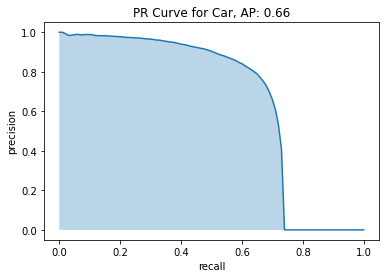

In [17]:
# You can directly compute normal AP metrics, and plot PR curve, using the gt_list and pred_list
stats = Detection.compute_statistics(gt_list, pred_list)

plt.figure()
plt.plot(stats['rec'], stats['prec'])
plt.fill_between(stats['rec'], stats['prec'], alpha=0.3)
plt.title(f'PR Curve for Car, AP: {stats["ap"]:.2f}')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [18]:
np.unique(gt_list[ml_mc].pred_labels, return_counts=True)

(array([3]), array([69]))